# Import necessary libraries


In [45]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
print(os.listdir("./dataset/"))
import warnings
warnings.filterwarnings('ignore')

['aclImdb', 'aclImdb_v1.tar.gz', 'IMDb_Reviews.csv']


# Import the training dataset

In [83]:
#importing the training data
imdb_data=pd.read_csv('./dataset/IMDb_Reviews.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


# EDA

In [7]:
#Summary of the dataset
imdb_data.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [9]:
#sentiment count
imdb_data.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

 * We can see that the dataset is balanced.



In [13]:
imdb_data.isnull().sum() #identifying missing values

review       0
sentiment    0
dtype: int64

In [18]:
#view duplicate reviews
review = imdb_data['review']
duplicated_review = imdb_data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review

,review,sentiment
2949,"""Go Fish"" garnered Rose Troche rightly or wron...",0
25198,"""Go Fish"" garnered Rose Troche rightly or wron...",0
23104,"""Three"" is a seriously dumb shipwreck movie. M...",0
27187,"""Three"" is a seriously dumb shipwreck movie. M...",0
23656,"""Witchery"" might just be the most incoherent a...",0
...,...,...
5080,this movie sucks. did anyone notice that the e...,0
43603,"well, the writing was very sloppy, the directi...",0
35664,"well, the writing was very sloppy, the directi...",0
40571,"when I first heard about this movie, I noticed...",1


In [19]:
#drop duplicate reviews
imdb_data.drop_duplicates(inplace = True)

In [20]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(imdb_data.shape[0],imdb_data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


# Data Cleaning

In [24]:
# Function to clean reviews.
def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    # Remove any non-word character and append the emoticons,
    # removing the noise character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [39]:
#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

In [43]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

In [53]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [54]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

## Text Stemming

In [25]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer_porter(text):
    token = []
    for word in text.split():
        token.append(porter.stem(word))
    
    return token

In [49]:
# copy the data
data = imdb_data.copy()

In [55]:
data['review']=data['review'].apply(preprocessor)
data['review']=data['review'].apply(remove_special_characters)
data['review']=data['review'].apply(clean_text)

In [56]:
#after processing
data.head()

,review,sentiment
0,teenager martha moxley maggie grace move high ...,1
1,ok really like kris kristofferson usual easy g...,0
2,spoiler read think watching movie although wou...,0
3,hi people seen wonderful movie im sure thet wo...,1
4,recently bought dvd forgetting much hated movi...,0


# EDA 

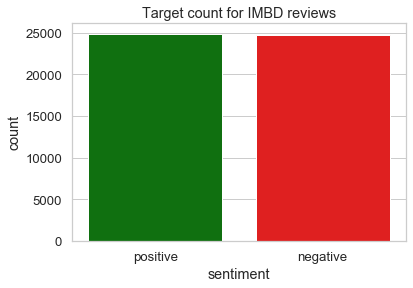

In [57]:
### Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Target count for IMBD reviews')
plt.show()

In [58]:
print('Positive reviews are', (round(data['sentiment'].value_counts()[0])),'i.e.', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative reviews are', (round(data['sentiment'].value_counts()[1])),'i.e.',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


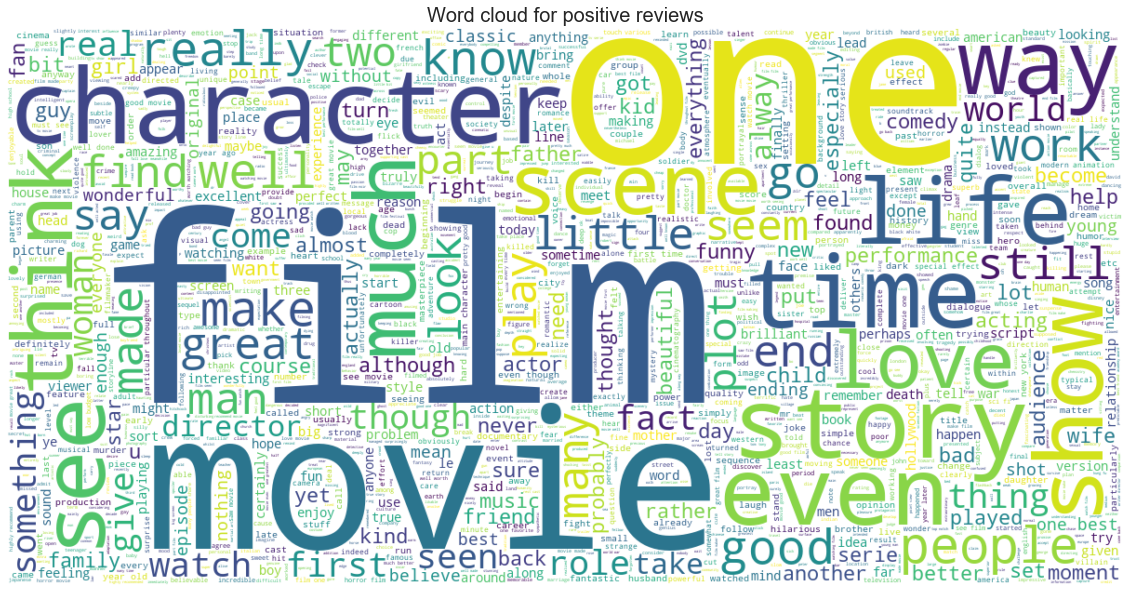

In [59]:
#word cloud for positive reviews
positive_data = data[data.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.savefig("wordCloud_pos.png")
plt.show()

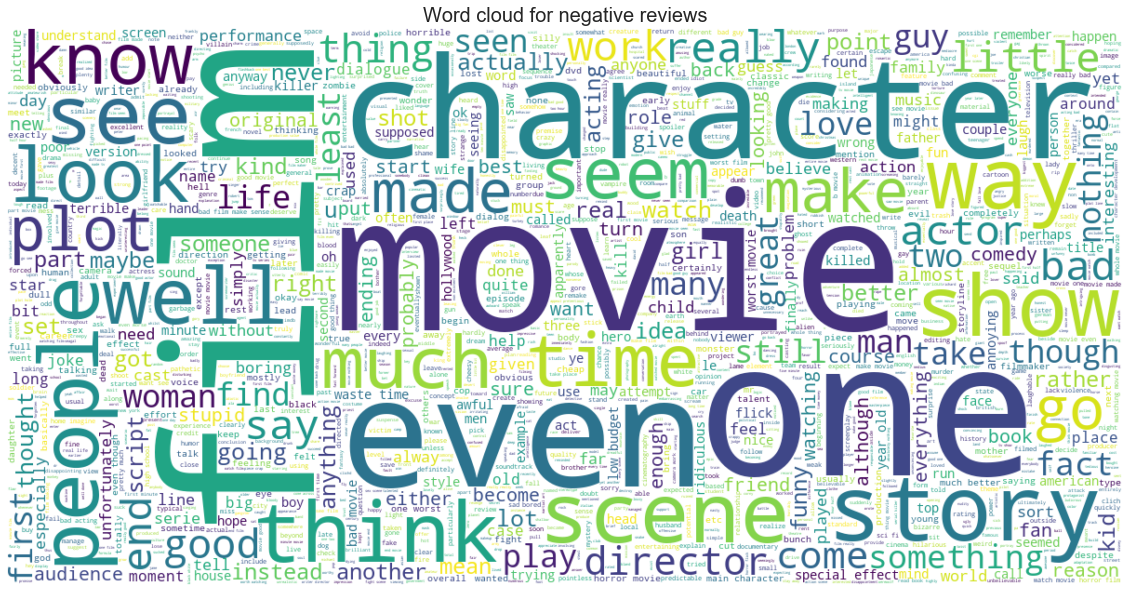

In [60]:
#word cloud for negative reviews
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.savefig("wordCloud_neg.png")
plt.show()


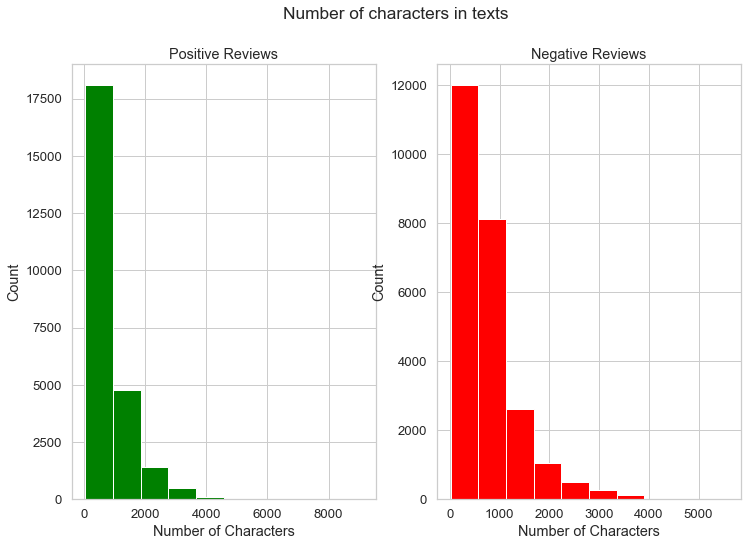

In [61]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.savefig("numb_car_texts.png")
plt.show()

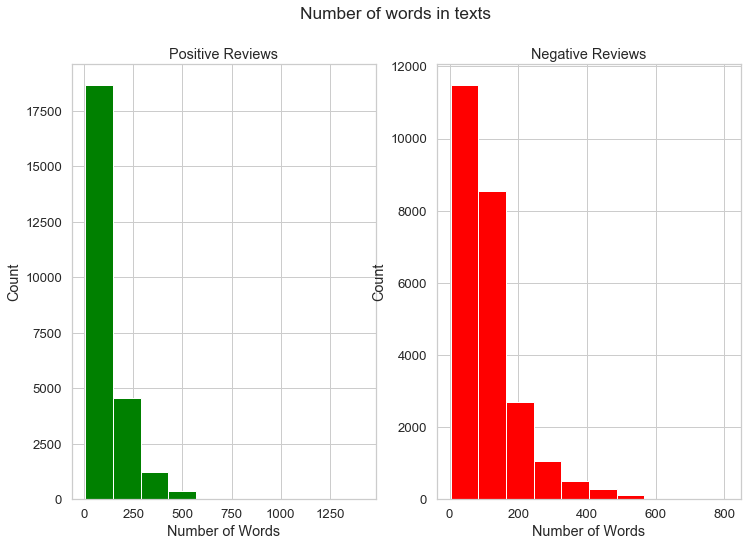

In [64]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.savefig("numb_words_texts.png")
plt.show()

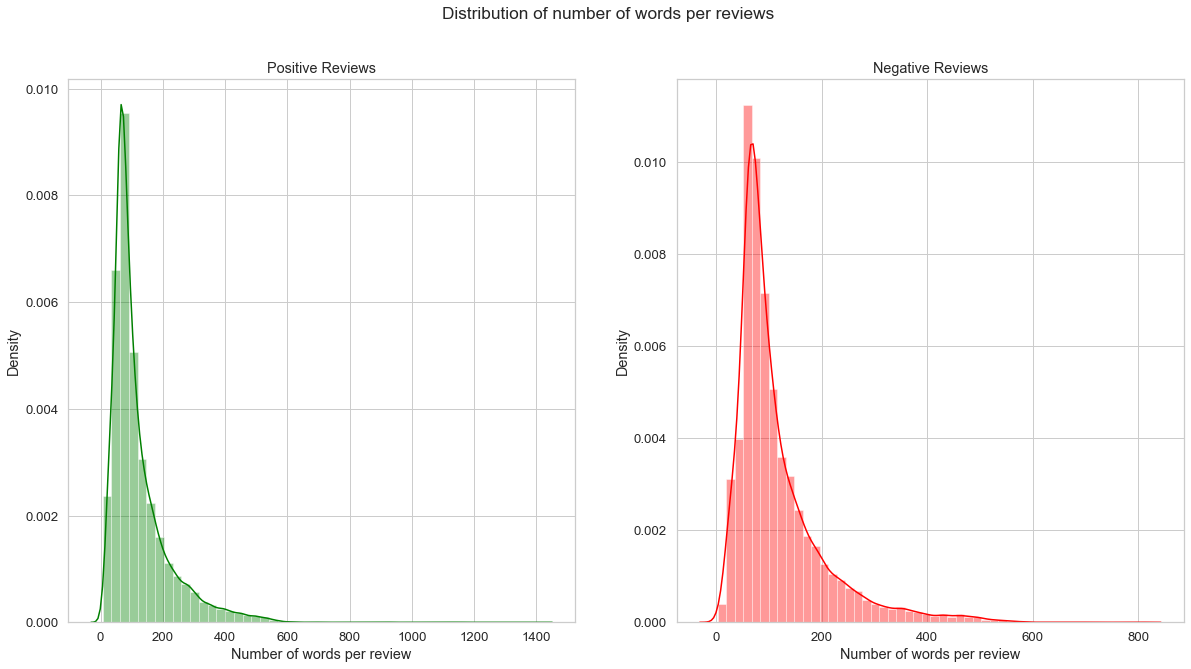

In [65]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.savefig("Distribution_of_number_words_per_reviews.png")
plt.show()

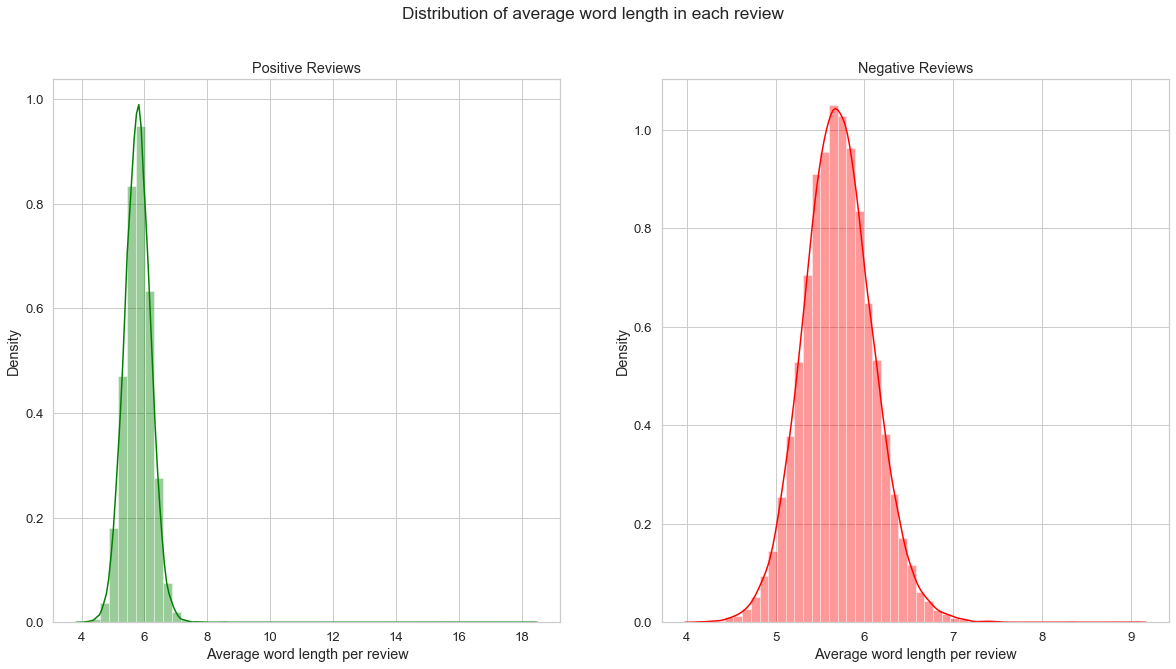

In [66]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Average word length per review')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Average word length per review')
fig.suptitle('Distribution of average word length in each review')
plt.savefig("Distribution_avg_number_words_per_reviews.png")
plt.show()

In [67]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

['teenager', 'martha', 'moxley', 'maggie', 'grace']

In [68]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movie,102458
1,film,92782
2,one,55018
3,like,40776
4,time,31191
5,good,29646
6,character,28109
7,story,25099
8,even,24653
9,get,24456


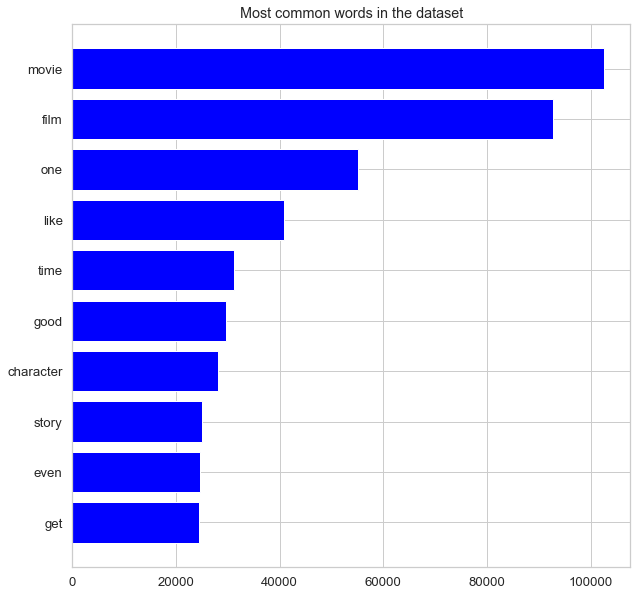

In [69]:
most_common = most_common.sort_values('countv')
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.savefig('mostCommon_words.png')
plt.show()


In [70]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

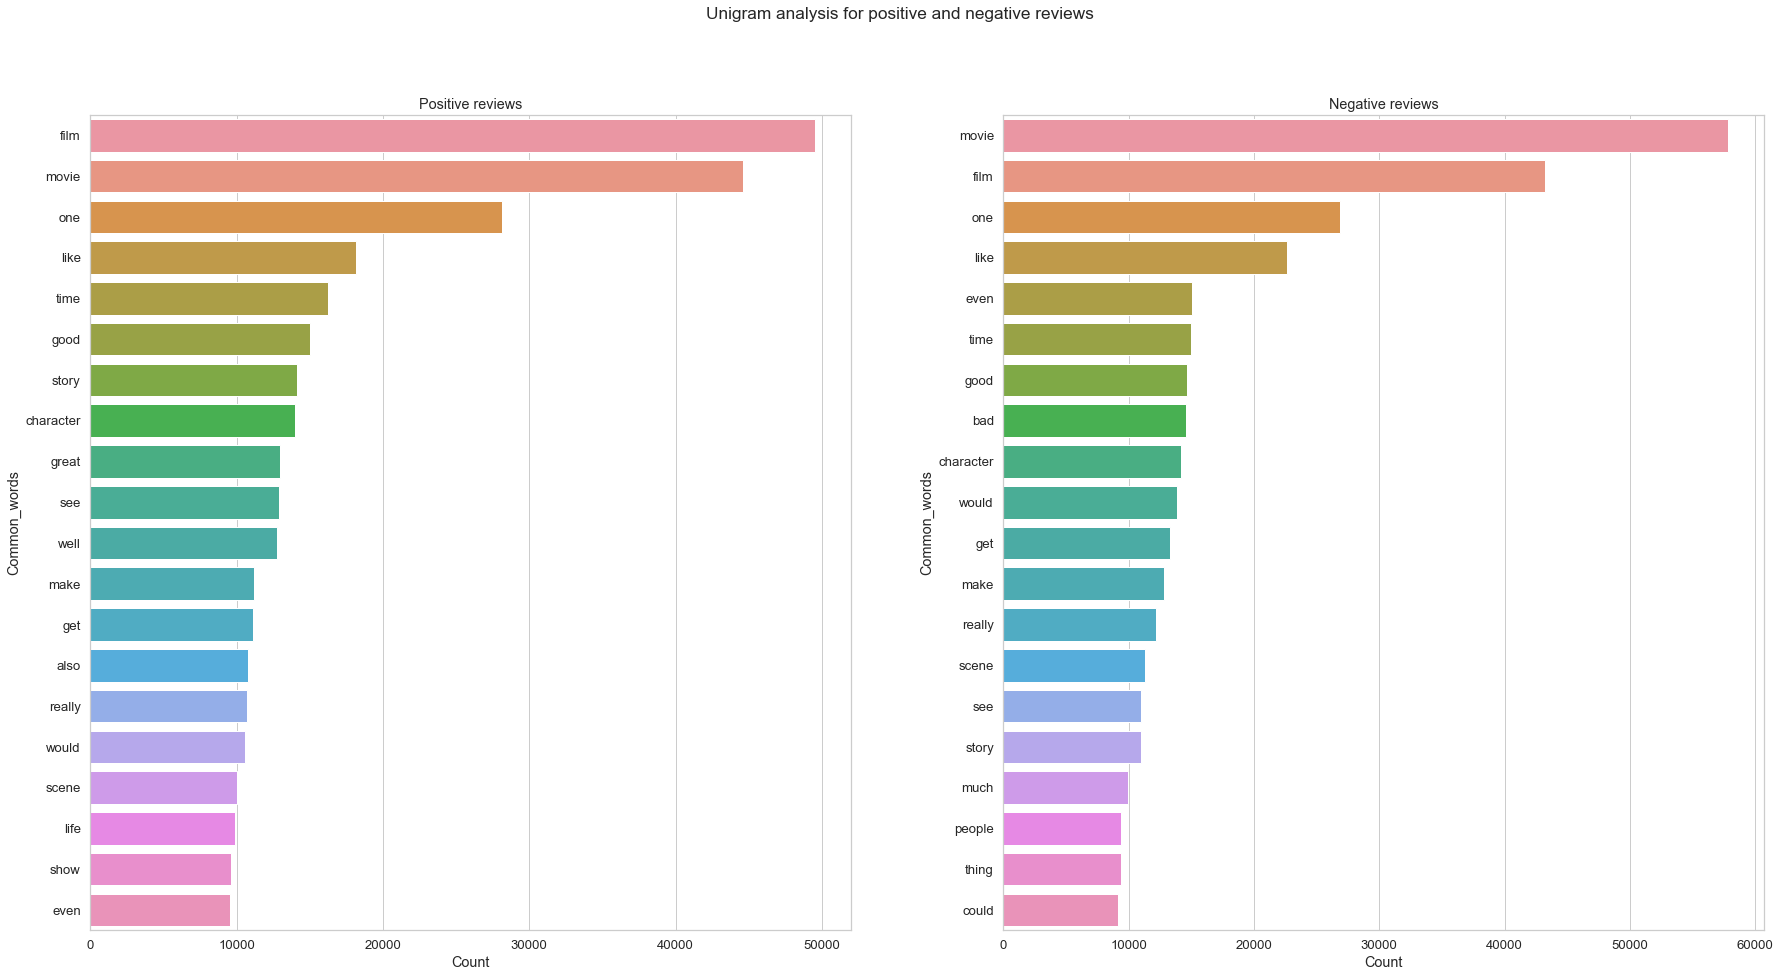

In [71]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
fig.savefig('unigram_pos_neg.png')
plt.show()

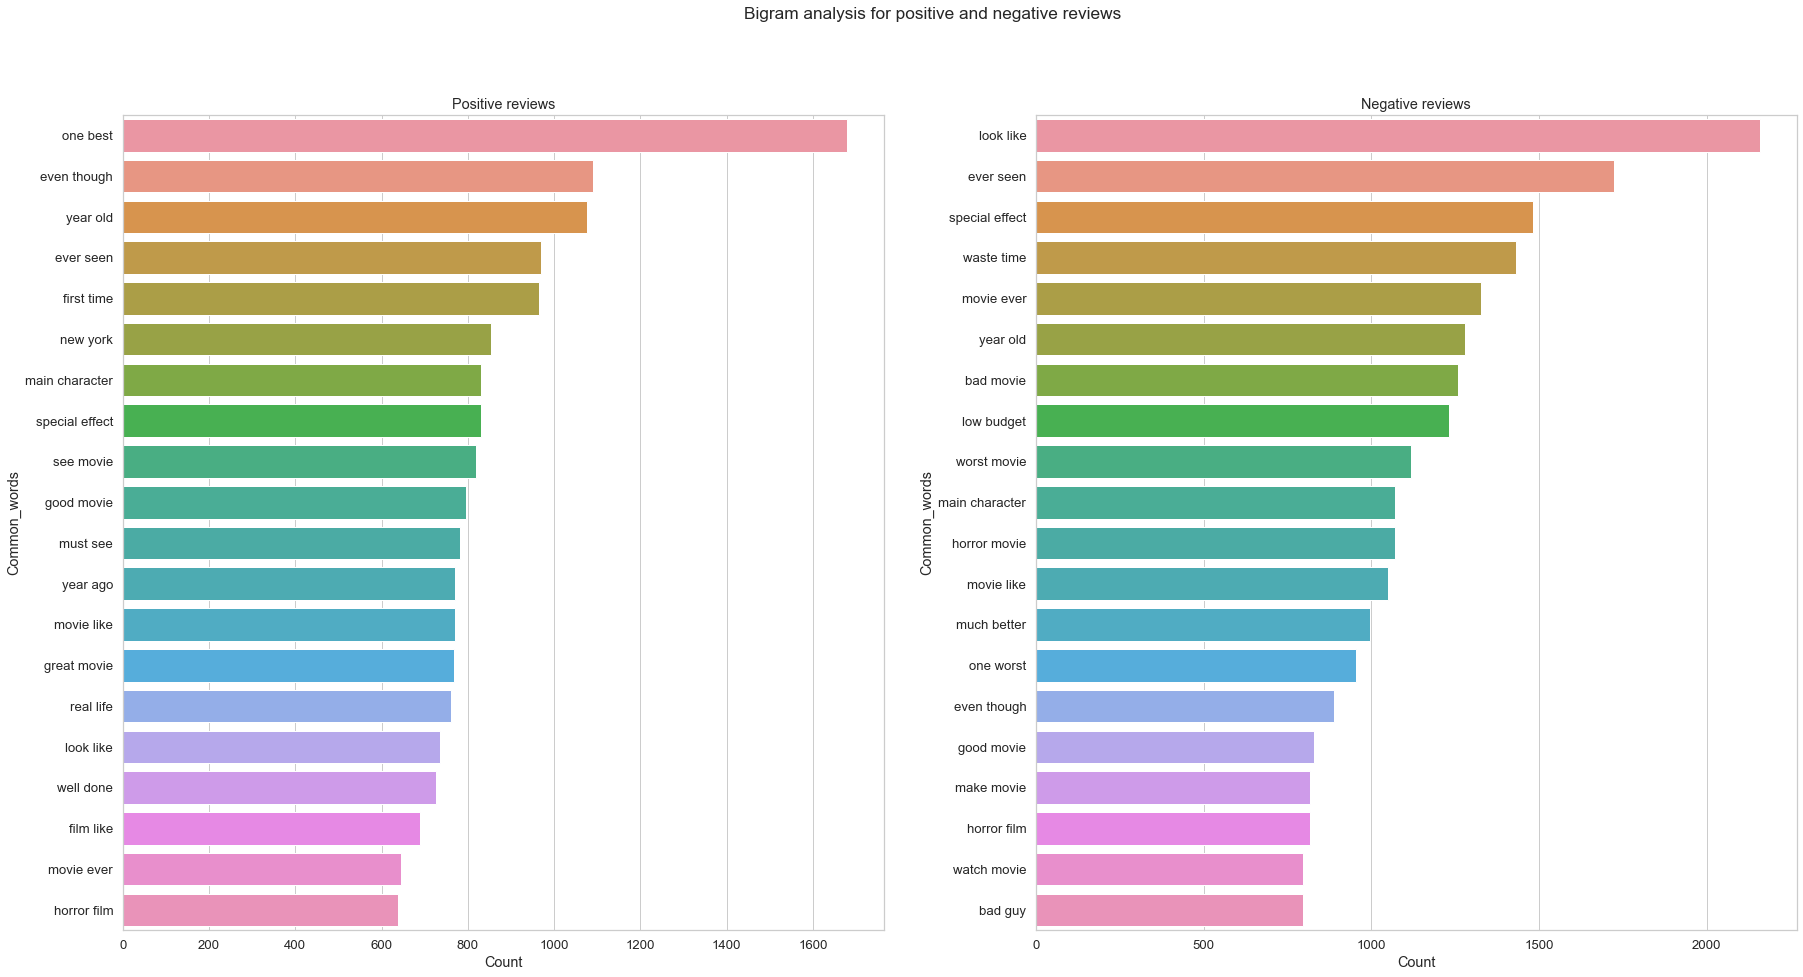

In [72]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
fig.savefig('bigram_pos_neg.png')
plt.show()

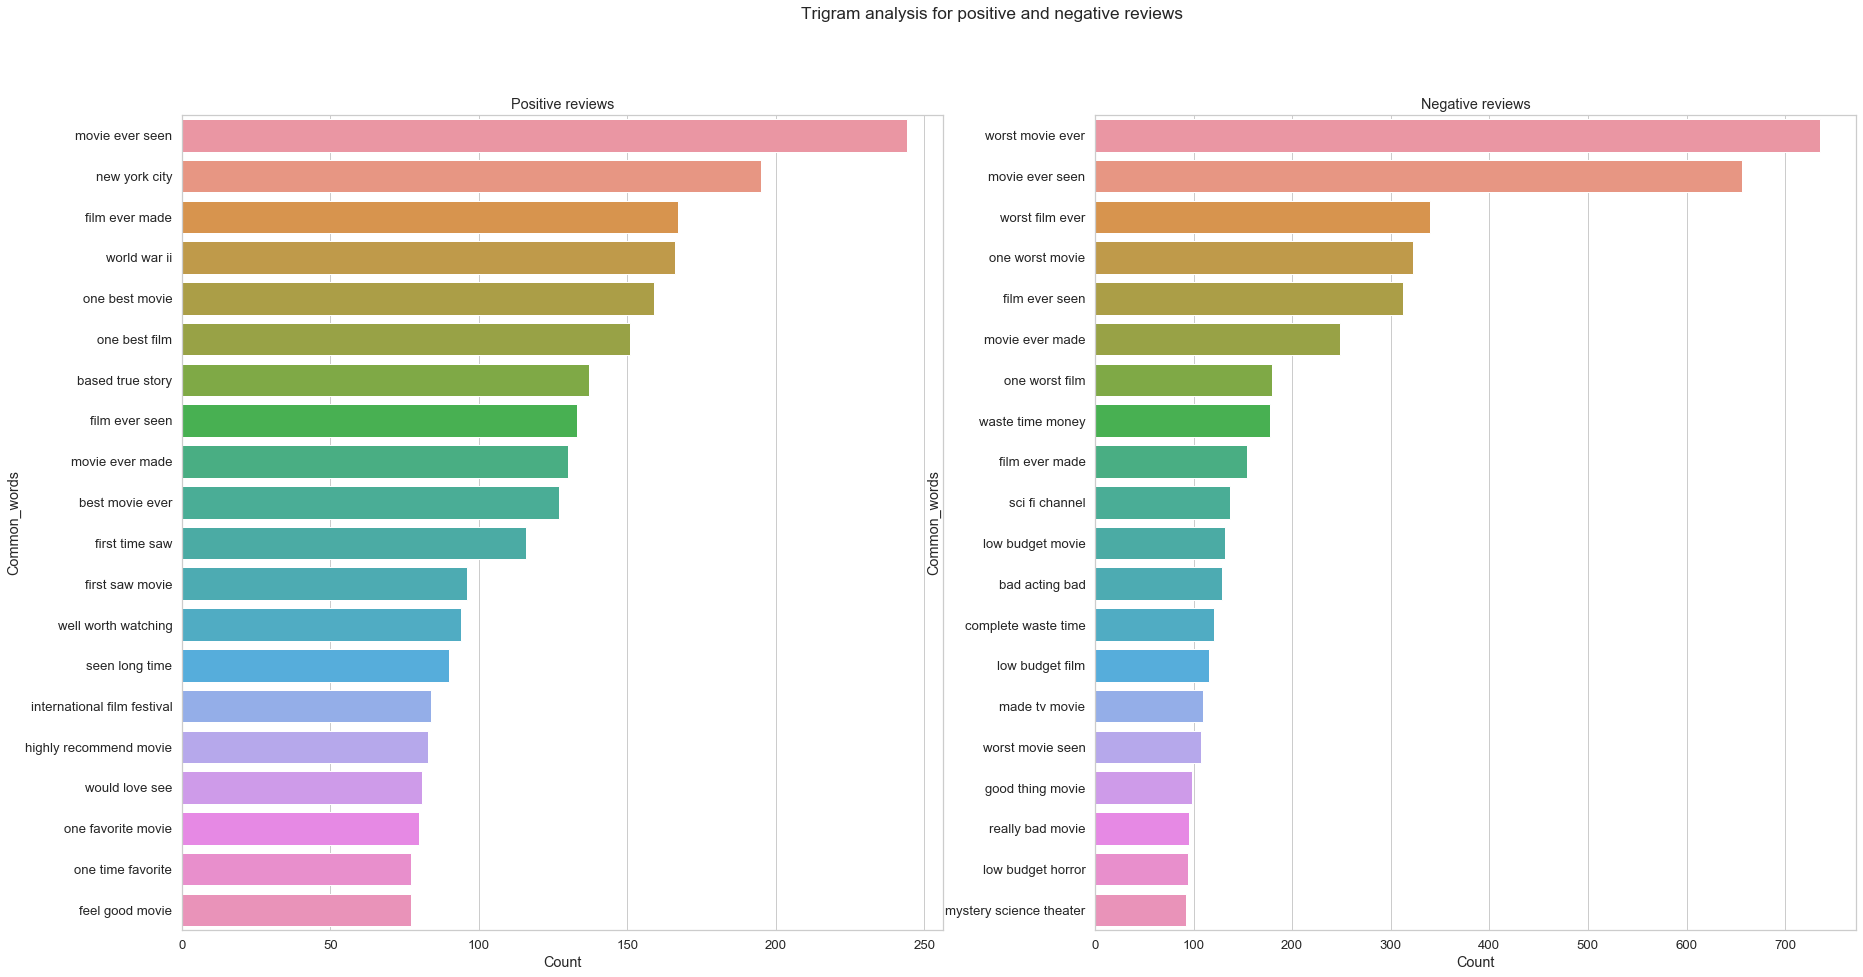

In [73]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
fig.savefig('trigram_pos_neg.png')
plt.show()

In [79]:
print(data.shape)
data.head()

(49582, 2)


,review,sentiment
0,teenager martha moxley maggie grace move high ...,1
1,ok really like kris kristofferson usual easy g...,0
2,spoiler read think watching movie although wou...,0
3,hi people seen wonderful movie im sure thet wo...,1
4,recently bought dvd forgetting much hated movi...,0


In [81]:
# save cleaned data.

data.to_csv("./dataset/cleaned_data.csv",)
print('[INFO....] Data saved to disk...')

[INFO....] Data saved to disk...
